In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
train = None
labels = None
for i in range(1,6):
    batch = unpickle("cifar-10-batches-py/data_batch_{}".format(i))
    if train is None:
        train = batch[b'data'].astype(np.float32)/255.0
        labels = batch[b'labels']
    else:
        train = np.concatenate((train, \
            batch[b'data'].astype(np.float32)/255.0), axis = 0)
        labels.extend(batch[b'labels'])
        
train_data = train
train_labels = np.array(labels).reshape((-1,1))

# Load test data
test = unpickle("cifar-10-batches-py/test_batch")
test_data = test[b'data'].astype(np.float32)/255.0
test_labels = np.array(test[b'labels']).reshape((-1,1))

label_names = unpickle("cifar-10-batches-py/batches.meta")

In [3]:
for key in label_names:
    print(key, label_names[key])

b'num_cases_per_batch' 10000
b'label_names' [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
b'num_vis' 3072


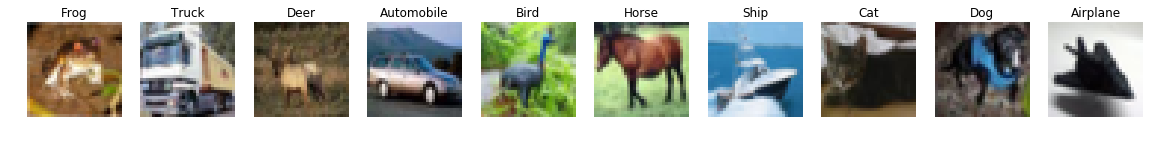

In [4]:
classnames = [x.decode("utf-8") for x in label_names[b'label_names']]
display_images = []
display_titles = []
temp_labels = list(range(10))
for i in range(len(train_data)):
    image = np.transpose(np.reshape(train_data[i], (-1, 3, 32, 32)), (0, 2, 3, 1))[0]
    if train_labels[i][0] in temp_labels:
        temp_labels.remove(train_labels[i])
        display_images.append(image)
        disp_name = classnames[train_labels[i][0]].capitalize()
        display_titles.append(disp_name)
fig, ax = plt.subplots(1,10, figsize=(20,2.3))

for i in range(10):
    ax[i].axis('off')
    ax[i].set_title(display_titles[i])
    ax[i].imshow(display_images[i])

plt.show()
fig.savefig('DatasetDemo.png')

In [4]:
num_components = 2
X_m = train_data - np.mean(train_data, 0).reshape(1,3072)
U,s,VT = np.linalg.svd(X_m,full_matrices=False)


In [6]:
components = VT[0:2,:].T
coords = X_m @ components

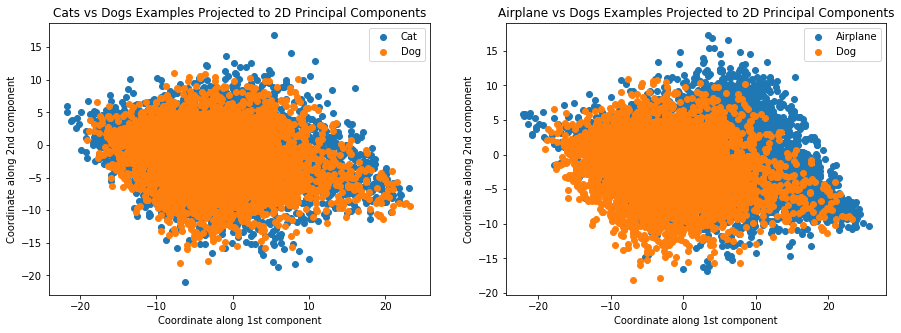

In [7]:
airplane_x = []
airplane_y = []
cats_x = []
cats_y = []
dogs_x = []
dogs_y = []
for i in range(len(X_m)):
    if train_labels[i] == 0:
        airplane_x.append(coords[i][0])
        airplane_y.append(coords[i][1])
    elif train_labels[i] == 3:
        cats_x.append(coords[i][0])
        cats_y.append(coords[i][1])
    elif train_labels[i] == 5:
        dogs_x.append(coords[i][0])
        dogs_y.append(coords[i][1])

fig, ax = plt.subplots(1,2, figsize=(15,5))
p1 = ax[0].scatter(cats_x, cats_y, label='Cat')
p2 = ax[0].scatter(dogs_x, dogs_y, label='Dog')
ax[0].set_xlabel("Coordinate along 1st component")
ax[0].set_ylabel("Coordinate along 2nd component")
ax[0].set_title("Cats vs Dogs Examples Projected to 2D Principal Components")
ax[0].legend()
p3 = ax[1].scatter(airplane_x, airplane_y, label = "Airplane")
p4 = ax[1].scatter(dogs_x, dogs_y, label = "Dog")
ax[1].set_xlabel("Coordinate along 1st component")
ax[1].set_ylabel("Coordinate along 2nd component")
ax[1].legend()
ax[1].set_title("Airplane vs Dogs Examples Projected to 2D Principal Components")
plt.savefig("2D.png")
plt.show()

In [7]:
bucketized_data = []
for i in range(10):
    bucket_i_labels = np.array([1 if train_labels[k] == i else 0 for k in range(len(train_data)) ])
    bucketized_data.append(np.array(bucket_i_labels))
    
# Make sure I bucketized data correctly into separate classes
print(bucketized_data)

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 1]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 1, ..., 1, 0, 0])]


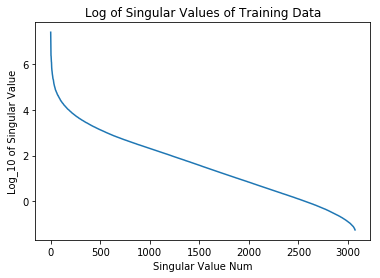

In [7]:
plt.plot(np.arange(len(s)), np.log(s))
plt.title("Log of Singular Values of Training Data")
plt.xlabel("Singular Value Num")
plt.ylabel("Log_10 of Singular Value")
plt.savefig("SingularValues.png")
plt.show()


In [5]:
from sklearn.svm import SVC
import pickle
classnames = [x.decode("utf-8") for x in label_names[b'label_names']]
components = VT[0:200,:].T
coords = X_m @ components

In [18]:
components = VT[0:200,:].T
coords = X_m @ components
classifiers = []
average_scores = []
for c in [0.001, 0.01, 0.1, 1, 10, 100]:
    print("Testing c = {}".format(c))
    scores = []
    for i in range(10):
        svm = SVC(C = c, gamma='auto', max_iter=100)
        svm.fit(coords, bucketized_data[i])
        scores.append(svm.score(coords, bucketized_data[i]))
        classifiers.append(svm)
    average_scores.append(sum(scores)/len(scores))


Testing c = 0.001


/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/du

Testing c = 0.01


/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/du

Testing c = 0.1


/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/du

Testing c = 1


/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/du

Testing c = 10


/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/du

Testing c = 100


/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/dureedo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/du

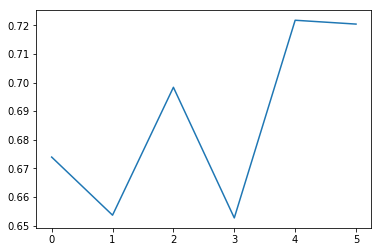

In [19]:
plt.plot(average_scores)
plt.show()

In [8]:
classifiers = []
for i in range(10):
    with open("{}_classifier_weights_C10.pkl".format(classnames[i]), "rb") as f:
        svm = pickle.load(f)
        classifiers.append(svm)
        
scores = []
for i, classifier in enumerate(classifiers):
    scores.append(classifier.score(coords, bucketized_data[i]))


    

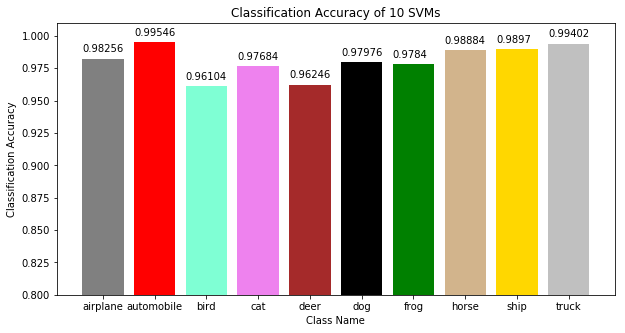

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bars = ax.bar(classnames, scores, color=['gray', 'red', 'aquamarine', 'violet', 'brown', 'black', 'green', 'tan', 'gold', "silver"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
ax.set_ylim(0.8,1.01)
ax.set_title("Classification Accuracy of 10 SVMs")
ax.set_ylabel("Classification Accuracy")
ax.set_xlabel("Class Name")
plt.savefig("SVMResults1.png")
plt.show()

In [9]:
# Based on singular values, first 200 or so seem important
# Don't run this cell more than once. It takes a very long time
components = VT[0:200,:].T
coords = X_m @ components
classifiers = []
for i in range(10):
    svm = SVC(C = 10, gamma='auto')
    svm.fit(coords, bucketized_data[i])
    with open("{}_classifier_weights_C10.pkl".format(classnames[i]), "wb") as f:
        pickle.dump(svm, f)
    classifiers.append(svm)


In [10]:
classifiers = []
for i in range(10):
    with open("{}_classifier_weights_C10.pkl".format(classnames[i]), "rb") as f:
        svm = pickle.load(f)
        classifiers.append(svm)
        
def predict_example(image):
    mean_subtracted = image - np.mean(train_data, 0).reshape(1,3072)
    projection = mean_subtracted @ components
    predictions = []
    for classifier in classifiers:
        predictions.append(classifier.decision_function(projection)[0])
    return np.argmax(predictions)

    
correct = 0
total = 0
for i in range(len(test_data)):
    prediction = predict_example(test_data[i])
    if prediction == test_labels[i]:
        correct += 1
    total += 1
correct/total

0.5804